<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [1]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return sorted_base

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        return self.base.tolist().index(list(rep))

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d):
        #print("Creating basis: ", m, d)
        length = int(binom(d,m))
        base = np.array(create_basis_(m, d, length))
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals

    def __init__(self, m, d):
        self.m = m
        self.d = d
        self.size = int(binom(d,m))
        (self.base, self.canonicals) = self.create_basis(m, d)


# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i]
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = np.expand_dims(state, axis=1)
    state_expanded = np.expand_dims(state_expanded, axis=1)
    rho_2_arrays = rho_2_arrays[np.newaxis, :, :, :, :]
    print(state_expanded.shape, rho_2_arrays.shape)
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))
    return mat

def rho_2_kkbar_gen(m, rho_2_arrays):
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada

    rho_2_arrays_kkbar = rho_2_arrays[i, j, :, :]

    return rho_2_arrays_kkbar

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

#@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            # v1 = vect @ bd_m @ b_m @ vect Para estados puros
            # Mult de b's y filleo de mat
            coef = np.trace(vect @ bd_m @ b_m)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


/var/tmp/ipykernel_5719/3558866515.py:248: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def gamma_lamba_inv(x):


## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [2]:
m = 3
d = 6
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)

In [3]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
eps = 0.00001

def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2))) + eps * np.random.random((2*m,2*m))
    
    # Construimos la mat de energía
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    
    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G

    hi = -np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays[:, :, :, :], axis=(0, 1))

    return (h0, hi)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [4]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2023-12-06 17:53:59.588207: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 17:54:00.346451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 17:54:00.346490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 17:54:00.350943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 17:54:00.727857: I tensorflow/core/platform/cpu_feature_g

'/device:GPU:0'

In [5]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d)
print(nm2_basis.base)
t_basis = fixed_basis(2, basis.d)
# rho1
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
print(m1_basis.base)
nm1_basis = fixed_basis(basis.m-m, d)


15
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]
6
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


### Algunos benchmarks y funciones auxiliares

In [6]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [7]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)
    
    return tf.cast(res, tf.float32)

# Aux function
def outer_product(vector):
    return tf.einsum('i,j->ij', vector, vector)

def pure_state(h):
    e, v = tf.linalg.eigh(h)
    fund = v[:,:,0]
    d = tf.map_fn(outer_product, fund)
    return d
    

### Construccion de dataset

#### Version sincrónica

In [8]:
import time
from tqdm import tqdm
# Config
num_samples = 50000
use_gpu = True
gpu_batch_size = 1024

# Construccion de parametros y matrices auxiliares
rho1_size = m1_basis.size
rho2_size = m2_basis.size
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(basis.m, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)

if use_gpu:
    print(tf.test.gpu_device_name())
    datasets = []
    for i in tqdm(range(num_samples//gpu_batch_size+1)):
        size = basis.d*(basis.d+1)//2
        # En una primera versión vamos a pasar una mat proporcional a range(0,m) para energias
        # y como interacción una cte G por ones(m,m)
        h_labels = [(np.random.rand(), np.random.rand()) for _ in range(0,gpu_batch_size)] # Generamos los generadores
        hamil_base = tf.constant(h_labels, dtype=tf.float32)
        h_arr = np.zeros((gpu_batch_size, basis.size, basis.size))
        for i, (e, g) in enumerate(h_labels):
            (h0, hi) = two_body_hamiltonian(t_basis.size, basis.m, e*np.arange(0, basis.m), g * np.ones((m,m)), rho_1_arrays_tf, rho_2_arrays_tf)
            h_arr[i,:,:] = h0 + hi
        # Estados térmicos
        state = thermal_state_tf(h_arr) 
        state = tf.cast(state, dtype=tf.float32)
        # Estados puros
        #state = pure_state(h_arr)
        #rho_1_input = rho_1_tf(state, rho_1_arrays_tf)
        rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)

        datasets.append(tf.data.Dataset.from_tensor_slices(((rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

2023-12-06 17:54:08.361003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2023-12-06 17:54:10.777593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:41<00:00,  2.07s/it]


#### Filleo de dataset

In [9]:
import pickle
# Save and load dataset
save_dataset = False
load_dataset = False
path = "/home/agus/TF"
#num_samples = 5000000
if save_dataset:
    tf.data.Dataset.save(dataset, path)
    with open("/home/agus/"+'/file.pkl', 'wb') as file:
        pickle.dump(beta_input, file)
if load_dataset:
    dataset = tf.data.Dataset.load(path)
    with open("/home/agus/"+'file.pkl', 'rb') as file:
        beta_input = pickle.load(file)


In [10]:
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = 256
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]

In [11]:
# Cardinality no funciona con los datasets generados por GPU
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)


Validation Dataset Size: -2


### Definición de modelo

In [12]:
# Definicion de layers basado en Conv 2D

# Factor de cantidad de filtros
lf = 8  
conv_limit = (rho2_size - 4) // 4 
initial_dense = (lf*2**(conv_limit-1)*((rho2_size-(conv_limit-1))//2)**2) // 8
## rho 1
rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')

# Procesamos el primer input
conv_rho2 = tf.keras.layers.Conv2D(lf*2**conv_limit, (2, 2), activation='relu')(rho2_layer)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
for j in [(2**conv_limit - 2**k) for k in range(1,conv_limit)]:
    conv_rho2 = tf.keras.layers.Conv2D(lf*j, (2, 2), activation='relu')(conv_rho2 if 2**j != 1 else rho1_layer)
    conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)

conv_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)
#flatten_rho1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(flatten_rho1)

#local_size = basis.size*basis.size
local_size = hamil_base_size

#dense1 = tf.keras.layers.Dense(8*8*4*4, activation='relu')(dense1)
#dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten_rho1)
#dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten_rho1)
dense1 = tf.keras.layers.Dense(initial_dense // 4, activation='relu')(flatten_rho2)
#dense1 = tf.keras.layers.Dense(initial_dense//2, activation='relu')(dense1)

output = tf.keras.layers.Dense(2)(dense1)


# Creamos el modelo y compulamos
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer, fund_layer], outputs=output)
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho2 (InputLayer)           [(None, 15, 15, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        160       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        2064      
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 16)          0     

In [21]:
# Modelo denso + fundamental
rho2_layer =  tf.keras.layers.Input(shape=(basis.m,basis.m, 1), name='rho1')
flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')
#flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
#flatten_fund = tf.keras.layers.Flatten()(fund_layer)

dense1 = tf.keras.layers.concatenate([flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])
#dense1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(dense1)

local_size = 2
l=4
layer_s = [128//2**i for i in reversed(range(1,l))]
for i in range(0,l-1):
    dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)
# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)
model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho1 (InputLayer)           [(None, 3, 3, 1)]         0         
                                                                 
 flatten_8 (Flatten)         (None, 9)                 0         
                                                                 
 concatenate_7 (Concatenate  (None, 9)                 0         
 )                                                               
                                                                 
 dense_34 (Dense)            (None, 16)                160       
                                                                 
 dense_35 (Dense)            (None, 32)                544       
                                                                 
 dense_36 (Dense)            (None, 64)                2112      
                                                           

In [15]:
layer_s

[10, 16, 32]

In [14]:
# LOSS FUNCTIONS
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff + tf.reduce_mean(tf.square(h_true - h_pred)) * 100

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

# Custom loss function based on h eigenvalues
def eig_loss(h_pred, h_true):
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# MSE with a factor
def mse_f(h_pred, h_true):
    f = 100
    return tf.reduce_mean(tf.square(h_true - h_pred))*f

# Spectral radius loss
def spectral_loss(h_pred, h_true):
    eig = tf.math.real(tf.linalg.eigvals(tf.reshape(h_true-h_pred, (-1, fund_size, fund_size))))
    return tf.math.reduce_max(tf.abs(eig))

# Hamiltonian MSE loss (using generators)
def base_mse_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    mat = tf.reshape(h_pred-h_true, (-1, fund_size, fund_size))
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on h eigenvalues (using generators)
def base_eig_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# Custom loss function based on rho1 eigenvals
## Auxiliary function
def base_to_rho_1_tf(base_pred):
    h = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h = tf.reshape(h, (-1, fund_size, fund_size))
    state = thermal_state_tf(h)
    rho1 = rho_1_tf(state, rho_1_arrays_tf)
    return rho1
    
def rho1_loss(base_pred, base_true):
    mat = base_to_rho_1_tf(base_pred) - base_to_rho_1_tf(base_true)
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on rho1 eigenvals (using generators)
def base_rho1_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000


## Entrenamiento

In [22]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

# Compile the model
model.compile(optimizer=Adam(),
              loss='MSE',  
              metrics=['accuracy', 'mean_squared_error'])

# Train the model
num_epochs = 10
device_name = tf.test.gpu_device_name()

with tf.device('/gpu:0'):
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/10


2023-12-06 17:57:54.805562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2023-12-06 17:57:56.017390: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ec4d2aff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 17:57:56.017421: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2023-12-06 17:57:56.030604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 17:57:56.365453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-12-06 17:57:56.479764: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for 

    146/Unknown - 3s 3ms/step - loss: 0.0434 - accuracy: 0.8078 - mean_squared_error: 0.0434

2023-12-06 17:57:57.716537: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9743857298035749497
2023-12-06 17:57:57.716594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13445621741850301056


157/157 [==============================] - 3s 6ms/step - loss: 0.0408 - accuracy: 0.8187 - mean_squared_error: 0.0408 - val_loss: 0.0020 - val_accuracy: 0.9760 - val_mean_squared_error: 0.0020
Epoch 2/10
 57/157 [=========>....................] - ETA: 0s - loss: 6.5063e-04 - accuracy: 0.9816 - mean_squared_error: 6.5063e-04

2023-12-06 17:57:58.179602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9743857298035749497


157/157 [==============================] - 1s 5ms/step - loss: 4.3003e-04 - accuracy: 0.9856 - mean_squared_error: 4.3003e-04 - val_loss: 2.1912e-04 - val_accuracy: 0.9922 - val_mean_squared_error: 2.1912e-04
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 1.5835e-04 - accuracy: 0.9940 - mean_squared_error: 1.5835e-04 - val_loss: 1.1159e-04 - val_accuracy: 0.9972 - val_mean_squared_error: 1.1159e-04
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 9.0027e-05 - accuracy: 0.9954 - mean_squared_error: 9.0027e-05 - val_loss: 6.6300e-05 - val_accuracy: 0.9968 - val_mean_squared_error: 6.6300e-05
Epoch 5/10
157/157 [==============================] - 1s 5ms/step - loss: 5.6953e-05 - accuracy: 0.9965 - mean_squared_error: 5.6953e-05 - val_loss: 4.6116e-05 - val_accuracy: 0.9977 - val_mean_squared_error: 4.6116e-05
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 3.9948e-05 - accuracy: 0.9974 - mean_squared_error: 3.994

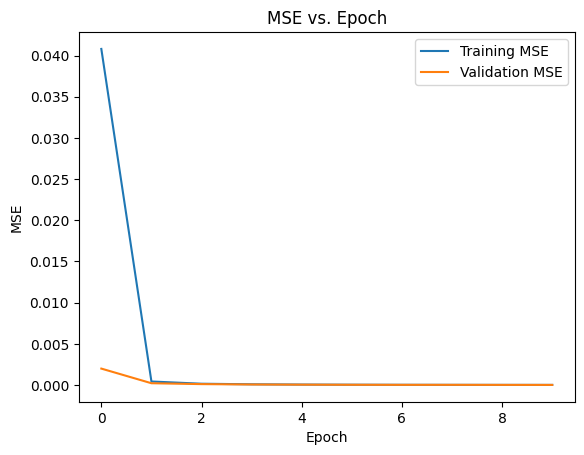

In [23]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

In [57]:
# Assuming you have a validation dataset (val_dataset)
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

8/8 [==============================] - 0s 1ms/step


In [61]:
input_data

<tf.Tensor: shape=(256, 3, 3), dtype=float32, numpy=
array([[[0.53074   , 0.0716527 , 0.08921236],
        [0.0716527 , 0.240579  , 0.07165284],
        [0.08921236, 0.07165284, 0.09665501]],

       [[0.6273009 , 0.05147061, 0.07807299],
        [0.05147061, 0.20872231, 0.05147063],
        [0.07807299, 0.05147063, 0.05382173]],

       [[0.58406126, 0.07111894, 0.09698345],
        [0.07111894, 0.23221023, 0.07111884],
        [0.09698345, 0.07111884, 0.08192606]],

       ...,

       [[0.49247777, 0.08055238, 0.09435193],
        [0.08055238, 0.25239825, 0.08055242],
        [0.09435193, 0.08055242, 0.11943947]],

       [[0.2809168 , 0.07624207, 0.07636237],
        [0.07624207, 0.26088822, 0.07624208],
        [0.07636237, 0.07624208, 0.24196701]],

       [[0.29098335, 0.03432403, 0.03487515],
        [0.03432403, 0.22659275, 0.03432403],
        [0.03487515, 0.03432403, 0.17278518]]], dtype=float32)>

In [64]:
from sklearn.metrics import mean_squared_error

# Vemos algunos valores
for e in val_dataset:
    for i in range(0, 4):
        print(e[1][i])
        print(predictions[i])
    break
    

RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
print(RMSE_pred, RMSE_rand)

tf.Tensor([0.7000782  0.80663306], shape=(2,), dtype=float32)
[0.70169055 0.8077759 ]
tf.Tensor([0.9917695  0.71810097], shape=(2,), dtype=float32)
[0.9901303  0.72209466]
tf.Tensor([0.848388  0.8957594], shape=(2,), dtype=float32)
[0.8478959  0.89457726]
tf.Tensor([0.09022991 0.8853695 ], shape=(2,), dtype=float32)
[0.09031808 0.884185  ]
0.0035659713 0.40514684


In [ ]:
m_size = basis.size
rho_1_pred = []
rho_1_actual = []
norm = []
norm_rand = []
printear =  False

for e in val_dataset:
    for i in range(0, 3 if printear else batch_size):
        # Valores actuales
        #h = e[1][i].numpy().reshape(basis.size,basis.size)
        h_true = gen_to_h(e[1][i], rho_1_arrays)
        #print(h) if printear else 0
        r = max(np.linalg.eigvals(e[0][i]))
        rho_1_actual.append(r)

        print(h_true) if printear else 0
        print(r) if printear else 0

        # Valores predichos
        #h = predictions[i].reshape(basis.size,basis.size)
        h_pred = gen_to_h(predictions[i], rho_1_arrays)
        beta = 1
        # Estado térmico
        state = thermal_state(h_pred, beta)
        # Estado puro
        #state = pure_state(h_pred)
        rho1 = np.array(rho_1(basis.d, state, rho_1_arrays))
        r = max(np.sort(linalg_d.eigvals(rho1).real))
        rho_1_pred.append(r)

        print(h_pred) if printear else 0
        print(r) if printear else 0
        

        # Normas
        norm.append(np.linalg.norm(h_true-h_pred, ord='fro'))
        print(f'Norma {norm[-1]}') if printear else 0
        ## Vamos a comparar con un h aleatorio
        size = basis.d*(basis.d+1)//2
        base = np.random.uniform(low=0, high=1.0, size=(size,))
        h_rand = gen_to_h(base, rho_1_arrays)
        norm_rand.append(np.linalg.norm(h_true-h_rand, ord='fro'))
        #print(f'Norma random {norm_rand[-1]}') if printear else 0
        print('') if printear else 0
        


    # e contiene todo el batch y nos basta con uno
    break

In [ ]:
print(e[1][10])
predictions[10]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

f=1
rho_1_actual = np.array(rho_1_actual)
rho_1_pred = np.array(rho_1_pred)
#print(mean_squared_error(rho_1_pred, rho_1_actual))

print('Rho1 based statistics')
print(np.mean(np.abs(rho_1_actual-rho_1_pred)))
print(np.mean(rho_1_actual)*f)
print('std')
print(np.std(rho_1_actual-rho_1_pred)*f)
print(np.std(rho_1_actual)*f)
print(np.std(rho_1_pred)*f)
plt.hist(np.array(rho_1_pred-rho_1_actual), bins=50)
plt.show()
print('H based statistics')
print(np.mean(norm), np.mean(norm_rand))
print(np.mean(norm_rand)/np.mean(norm))


# BEST: FACTOR 1/8 c/fund
## 500 epochs, 10M dataset
# BEST: FACTOR 1/9 s/fund
## 50 epochs, 5M dataset

In [ ]:
6.25/1.30

In [ ]:
# 25 epochs d = m*2
res = {}
res[5] = 35/8.19 
res[4] = 15/2.47
res[3] = 6.2/1.73

In [ ]:
print(res)

In [ ]:
# Get the weights of all dense layers in the model
dense_weights = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()
        if len(weights) > 0:
            dense_weights.append(weights[0])

# Visualize the weights of each dense layer
for i, weights in enumerate(dense_weights):
    plt.figure()
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Dense Layer {i+1} Weights Visualization")
    plt.show()


In [25]:
rho_2_arrays[9,0,0,9]

0.0

In [51]:
# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)
            if mat[i,j,0,9] != 0:
                print(v,w)

    return mat

r = rho_2_gen(basis, basis_m2, t_basis)
r[9,0,0,9]

[0 0 0 0 1 1] [0 1 1 0 0 0]


0.0

In [53]:
print(b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0])))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [38]:
b

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]], dtype=float32)

In [57]:
basis.base

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1, 1]])

In [55]:
col = 1
b = b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0]))
print(b.shape)
for x in range(0,b.shape[1]):
    if b[col,x] != 0:
        ind = x
        break
else:
    ind = NaN

print([basis.base[ind]], mll_basis.base[col])

(6, 20)
[array([0, 1, 0, 1, 1, 0])] [0 1 0 0 0 0]


In [14]:
m = 3
d = 2*m
basis = fixed_basis(m, d)
t_basis = fixed_basis(2, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)
ml_basis = basis_m1
mll_basis = basis_m2
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [10]:
t_basis = fixed_basis(2, d)
mll_basis = fixed_basis(basis.m-2, d)
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [15]:
def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2)))
    
    # Construimos la mat de energía
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    
    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G

    hi = -np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays[:, :, :, :], axis=(0, 1))

    return (h0, hi)


In [16]:
(h02,hi2) = two_body_hamiltonian(t_basis.size, m, [0,1,2], np.ones((3,3)), rho_1_arrays, rho_2_arrays)

In [23]:
rho_2_arrays

array([[[[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [24]:
print(rho_2_arrays[9,0,0,9])

0.0


In [ ]:
import numpy as np
rho_1_arrays = rho_1_gen(basis)

A = np.array([0, 1, 2])  # Your list with d elements

# Create a diagonal matrix with each element repeated twice
result_matrix = np.diagflat(np.kron(A, np.ones(2)))

print(result_matrix)
np.kron(A, np.ones(2))

mat = np.zeros((basis.size, basis.size))
for i in range(0,2*d):
    for j in range(0, 2*d):
        mat += result_matrix[i,j] * rho_1_arrays[i,j,:,:]


In [ ]:
mat = np.sum(result_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

In [ ]:
h0 == mat

In [37]:
d = 3
t_basis = fixed_basis(2, 2*d)
basis = fixed_basis(d, 2*d)
size = t_basis.size
#basis = fixed_basis(d, 2*d)
diag_elem = []
for x in t_basis.base:
    if all([x[i] == x[i+1] for i in range(0, 2*d, 2)]):
        print(x)
        diag_elem.append(t_basis.rep_to_index(x))

print(diag_elem)
# Veamos el GALERAZO de Wolfram
n = 4*d+1
print([-(k-1)*(2*k-n) for k in range(1,d+1)])


[1 1 0 0 0 0]
[0 0 1 1 0 0]
[0 0 0 0 1 1]
[0, 9, 14]
[0, 9, 14]


In [ ]:
m2_basis = fixed_basis(2, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-2, d)
print(nm2_basis.base)


In [ ]:
W = np.array([[1,2,3],[4,5,6],[7,8,9]])
index = [0,9,14]
mat = np.zeros((size,size))
for i in range(0,3):
    for j in range(0,3):
        mat[index[i], index[j]] = W[i,j]

In [ ]:
import numpy as np
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
#rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)

W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
W = np.ones((3,3))
index = [0, 9, 14]
size = 15  # Assuming size is the size of the matrix

# Create a meshgrid of indices
i, j = np.meshgrid(index, index, indexing='ij')

# Use the meshgrid indices to assign values from W to the specified positions in mat
mat = np.zeros((size, size))
mat[i, j] = W

# La mat... mat corresponde a los coeficientes en t_basis
inte = np.zeros((basis.size, basis.size))
for i in range(0, t_basis.size):
    for j in range(0, t_basis.size):
        inte += - mat[i, j] * rho_2_arrays[i,j,:,:]


In [ ]:
inte == hi

In [18]:
m = 3
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)

from numba import njit

# Parametros hamiltoniano
e = 1
eps = 0
e0 = np.zeros(2*d)
eigenspace_tol = 0.0001
for k in range(0, d):
    r = random.random() * eps * 0
    e0[2*k] = k*e+r
    e0[2*k+1] = k*e+r

@njit(parallel=True)
def base_hamiltonian_aux(basis, size, d, basis_m1, basis_m2):
    # Construccion de H
    d = d//2
    h0 = np.zeros((size,size), dtype=np.float32)
    for k in prange(0,2*d):
        h0 += e0[k] * np.dot(bd_aux(basis_m1, basis, k),b_aux(basis, basis_m1, k))
    hi = np.zeros((size, size), dtype=np.float32)
    for k in prange(0,d):
        for kb in prange(0,d):
            bd_terms = np.dot(bd_aux(basis_m1, basis, 2*k),bd_aux(basis_m2, basis_m1, 2*k+1))
            b_terms = np.dot(b_aux(basis_m1, basis_m2, 2*kb+1),b_aux(basis, basis_m1, 2*kb))
            hi += -1*np.dot(bd_terms,b_terms)

    return (h0, hi)

def base_hamiltonian(basis, basis_m1, basis_m2):
    return base_hamiltonian_aux(basis.base, basis.size, basis.d, basis_m1.base, basis_m2.base)

h0, hi = base_hamiltonian(basis, basis_m1, basis_m2)